<a href="https://colab.research.google.com/github/sda96/AIFFEL_3rd_hackerton_TUNiB_DKTC/blob/main/notebook/ChangHyun/baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 환경 설정

#### 사전에 다운 받은 패키지 불러오기

In [1]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')

my_path = '/content/notebooks'
# Colab Notebooks 안에 my_env 폴더에 패키지 저장
#os.symlink('/content/drive/MyDrive/TUNiB준비반/AIFFEL_3rd_hackerton_TUNiB_DKTC/reference/my_env', my_path)
sys.path.insert(0, my_path)
os.chdir('/content/drive/MyDrive/TUNiB준비반/AIFFEL_3rd_hackerton_TUNiB_DKTC/notebook/ChangHyun/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### matplotlib 한글 깨짐 해결 코드

In [5]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


해당 [사이트](https://teddylee777.github.io/colab/colab-korean)를 참고하여 위의 코드를 실행한 다음 런타임 재시작을 해주어야 합니다.

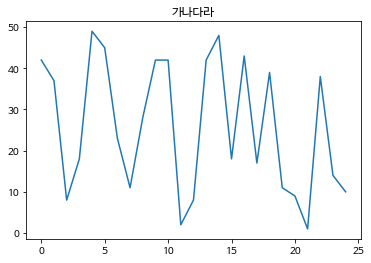

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 한글 지원 폰트
plt.rc('font', family='NanumBarunGothic')

# 마이너스 부호 
plt.rcParams['axes.unicode_minus'] = False

plt.plot(np.random.randint(1, 50, 25))
plt.title("가나다라")
plt.show()

#### 앞으로 사용할 패키지 불러오기

In [53]:
import re
import time
from glob import glob
from tqdm import tqdm
from packages import utils, tokenizer
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
from collections import defaultdict, Counter

import tensorflow as tf
import sentencepiece as spm
from transformers import TFBertForSequenceClassification, BertTokenizer
from transformers import TextClassificationPipeline

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

## 데이터 불러오기

In [28]:
now_path = os.getcwd()
data_path = utils.recurrent_find_data_path(now_path)
bucket_files = utils.get_data_paths(data_path)
file_dict = utils.files_to_pd_dict(bucket_files)

100%|██████████| 19/19 [00:11<00:00,  1.62it/s]


TUNiB 데이터 : sample_answersheet, test, train  
AI_HUB 데이터 : 나머지 데이터

In [29]:
keys = list(file_dict.keys())
print(f"불러온 데이터 파일명들 : {keys}")

불러온 데이터 파일명들 : ['sample_answersheet', 'test', 'train', 'A 음식점(15,726)_new', 'B 의류(15,826)_new', 'C 학원(4,773)_new', 'D 소매점(14,949)_new', 'E 생활서비스(11,087)_new', 'F 카페(7,859)_new', 'G 숙박업(7,113)_new', 'H 관광여가오락(4,949)_new', 'I 부동산(8,131)_new', '교통_최종본(0416)', '상수도_최종본(0416)', '여권 최종본(0416)', '차량등록_최종본(0429)']


In [30]:
print(f'위협 문장 훈련 데이터 개수 : {file_dict["train"].shape[0]}')
print(f'위협 문장 테스트 데이터 개수 : {file_dict["test"].T.shape[0]}')
file_dict["train"].head()

위협 문장 훈련 데이터 개수 : 3950
위협 문장 테스트 데이터 개수 : 400


,idx,class,conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...


AI_HUB 일반 대화 데이터 프레임 만들기

In [31]:
normal_conversation = []
for name in keys[3:]:
  if "SENTENCE" in file_dict[name].columns:
    normal_conversation.append(file_dict[name]["SENTENCE"])
  elif "question" in file_dict[name].columns:
    normal_conversation.append(file_dict[name]["question"])
    normal_conversation.append(file_dict[name]["answer"])

In [32]:
normal_pd = pd.DataFrame()
normal_pd["conversation"] = pd.concat(normal_conversation)
normal_pd["class"] = "일반 대화"
normal_pd = normal_pd.reset_index(drop=True)
normal_pd = normal_pd.reset_index()
normal_pd = normal_pd.rename(columns = {"index" : "idx"})

In [33]:
print(f'일반 문장 훈련 데이터 개수 : {normal_pd.shape[0]}')
normal_pd.head()

일반 문장 훈련 데이터 개수 : 101497


,idx,conversation,class
0,0,지금 배달되나요?,일반 대화
1,1,아 네 배달됩니다,일반 대화
2,2,짬뽕류는 어떤 게 있나요? 잘 나가는 짬뽕 있나요?,일반 대화
3,3,특해물 짬뽕도 있고 전복 새우 짬뽕도 있고 해물 종류도 새우 홍합 전복 없는 게 없습니다,일반 대화
4,4,전복 들어가는 거는 특해물 짬뽕 시켜야 돼요?,일반 대화


AI_HUB 데이터와 TUNiB 데이터를 합친 데이터 프레임 만들기

In [34]:
train = pd.concat([file_dict["train"], normal_pd]).reset_index(drop=True)
print(f'일반 문장 훈련 데이터 개수 : {train.shape[0]}')
train.head()

일반 문장 훈련 데이터 개수 : 105447


,idx,class,conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...


## 데이터 전처리

#### 결측데이터 제거

In [35]:
print(f'결측 데이터 제거전 데이터 개수 : {train.shape[0]}')
train = utils.remove_nan(train).reset_index(drop=True)
print(f'결측 데이터 제거전 데이터 개수 : {train.shape[0]}')

결측 데이터 제거전 데이터 개수 : 105447
결측 데이터 제거전 데이터 개수 : 105338


#### 특수문자, 공백 제거

In [36]:
def remove_punctuation(x):
  x = re.sub("[^ㄱ-ㅎ가-힣]+", " ", x)
  x = re.sub("[ ]+", " ", x)
  x = x.strip()
  return x

In [37]:
train["pre_conversation"] = train["conversation"].apply(lambda x : remove_punctuation(x))
train.head()

,idx,class,conversation,pre_conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...,지금 너 스스로를 죽여달라고 애원하는 것인가 아닙니다 죄송합니다 죽을 거면 혼자 죽...
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...,길동경찰서입니다 시 분 마트에 폭발물을 설치할거다 네 똑바로 들어 한번만 더 얘기한...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...,너 되게 귀여운거 알지 나보다 작은 남자는 첨봤어 그만해 니들 놀리는거 재미없어 지...
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...,어이 거기 예 너 말이야 너 이리 오라고 무슨 일 너 옷 좋아보인다 얘 돈 좀 있나...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...,저기요 혹시 날이 너무 뜨겁잖아요 저희 회사에서 이 선크림 파는데 한 번 손등에 발...


#### Label Encoding

In [38]:
bucket_class = []
label_names = ["협박 대화", "갈취 대화", "직장 내 괴롭힘 대화", 
               "기타 괴롭힘 대화", "일반 대화"]

for idx, label in enumerate(train["class"]):
  if label == label_names[0]:
    bucket_class.append(0)
  elif label == label_names[1]:
    bucket_class.append(1)
  elif label == label_names[2]:
    bucket_class.append(2)
  elif label == label_names[3]:
    bucket_class.append(3)
  elif label == label_names[4]:
    bucket_class.append(4)

train["class"] = bucket_class
train.head()

,idx,class,conversation,pre_conversation
0,0,0,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...,지금 너 스스로를 죽여달라고 애원하는 것인가 아닙니다 죄송합니다 죽을 거면 혼자 죽...
1,1,0,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...,길동경찰서입니다 시 분 마트에 폭발물을 설치할거다 네 똑바로 들어 한번만 더 얘기한...
2,2,3,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...,너 되게 귀여운거 알지 나보다 작은 남자는 첨봤어 그만해 니들 놀리는거 재미없어 지...
3,3,1,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...,어이 거기 예 너 말이야 너 이리 오라고 무슨 일 너 옷 좋아보인다 얘 돈 좀 있나...
4,4,1,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...,저기요 혹시 날이 너무 뜨겁잖아요 저희 회사에서 이 선크림 파는데 한 번 손등에 발...


## 데이터 분석 및 시각화

협박 대화             896
갈취 대화             981
직장 내 괴롭힘 대화       979
기타 괴롭힘 대화        1094
일반 대화          101388
Name: idx, dtype: int64


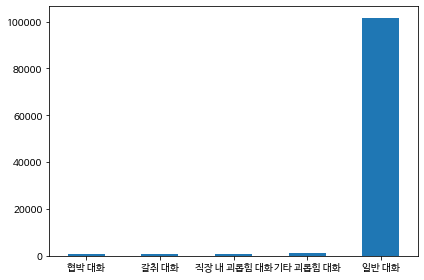

In [39]:
group_count = train.groupby("class").count().iloc[:,0]
group_count.index = label_names
print(group_count)
group_count.plot(kind="bar")
plt.xticks(rotation = 360)
plt.tight_layout()
plt.show()

#### Under Sampling

In [40]:
number_min_label = min(group_count)
print(f"레이블중에서 가장 개수가 작은 레이블의 개수 : {number_min_label}")

레이블중에서 가장 개수가 작은 레이블의 개수 : 896


In [41]:
under_train = train.groupby("class").sample(number_min_label, random_state = 200)
under_train.groupby("class").count().iloc[:,0]

class
0    896
1    896
2    896
3    896
4    896
Name: idx, dtype: int64

#### 훈련셋 검증셋 나누기

In [42]:
X = under_train["pre_conversation"].to_list()
Y = under_train["class"].to_list()

x_train, x_val_test, y_train, y_val_test = train_test_split(X, Y, 
                                                            test_size = 0.1, 
                                                            random_state = 200,
                                                            stratify = Y)
x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test,
                                                test_size = 0.5,
                                                random_state = 202,
                                                stratify = y_val_test)
print(f"x_train 개수 : {len(x_train)}")
print(f"y_train 개수 : {len(y_train)}")
print(f"x_val 개수 : {len(x_val)}")
print(f"y_val 개수 : {len(y_val)}")
print(f"x_test 개수 : {len(x_test)}")
print(f"y_test 개수 : {len(y_test)}")

print(f"훈련 데이터 레이블 비율 확인 : {Counter(y_train)}")
print(f"검증 데이터 레이블 비율 확인 : {Counter(y_val)}")
print(f"테스트 데이터 레이블 비율 확인 : {Counter(y_test)}")

x_train 개수 : 4032
y_train 개수 : 4032
x_val 개수 : 224
y_val 개수 : 224
x_test 개수 : 224
y_test 개수 : 224
훈련 데이터 레이블 비율 확인 : Counter({3: 807, 4: 807, 1: 806, 0: 806, 2: 806})
검증 데이터 레이블 비율 확인 : Counter({0: 45, 2: 45, 3: 45, 1: 45, 4: 44})
테스트 데이터 레이블 비율 확인 : Counter({2: 45, 1: 45, 4: 45, 0: 45, 3: 44})


## LSTM 적용하기

#### Tokenizing

In [54]:
model_type = "bpe"
data = X
vocab_size = 10000
add = False
train_test = "train"
temp_file = f"./{model_type}_{vocab_size}.tmp"

spm = tokenizer.SentencePiece(model_type,
                              data,
                              vocab_size,
                              add,
                              train_test,
                              temp_file)

In [68]:
token_x_train = [spm.EncodeAsIds(x) for x in x_train]
token_x_val = [spm.EncodeAsIds(x) for x in x_val]
token_x_test = [spm.EncodeAsIds(x) for x in x_test]

In [73]:
max_length_train = max(map(lambda x : len(x), token_x_train))
max_length_val = max(map(lambda x : len(x), token_x_val))
max_length_test = max(map(lambda x : len(x), token_x_test))
max_length = max([max_length_test, max_length_val, max_length_train])
max_length

333

#### 최대 길이로 패딩

In [135]:
from tensorflow.keras.preprocessing.sequence import pad_sequences


padded_x_train = pad_sequences(token_x_train, maxlen = max_length)
print(padded_x_train.shape)
padded_x_val = pad_sequences(token_x_val, maxlen = max_length)
print(padded_x_val.shape)
padded_x_test = pad_sequences(token_x_test, maxlen = max_length)
print(padded_x_test.shape)

y_train = np.array(y_train).reshape(-1, 1)
y_val = np.array(y_val).reshape(-1, 1)
y_test = np.array(y_test).reshape(-1, 1)

(4032, 333)
(224, 333)
(224, 333)


#### Tensorflow dataset으로 변환

In [139]:
train_dataset = tf.data.Dataset.from_tensor_slices((padded_x_train, y_train))
train_dataset = train_dataset.shuffle(1000).batch(16)
val_dataset = tf.data.Dataset.from_tensor_slices((padded_x_val, y_val))
val_dataset = val_dataset.shuffle(1000).batch(16)
tmp_x, tmp_y = next(iter(train_dataset))
print(tmp_x)
print("\n")
print(tmp_y)

tf.Tensor(
[[   0    0    0 ... 8851 1063 3014]
 [   0    0    0 ...  139   36 5587]
 [   0    0    0 ...   88 5222  129]
 ...
 [   0    0    0 ... 3632   37  334]
 [   0    0    0 ... 1243 1082 1872]
 [   0    0    0 ... 1723  112 3335]], shape=(16, 333), dtype=int32)


tf.Tensor(
[[4]
 [0]
 [4]
 [3]
 [1]
 [3]
 [4]
 [3]
 [2]
 [1]
 [0]
 [3]
 [2]
 [1]
 [2]
 [3]], shape=(16, 1), dtype=int64)


#### Functional API LSTM model

In [147]:
inputs = tf.keras.layers.Input(shape = (padded_x_train.shape[1]))
layers = tf.keras.layers.Embedding(input_dim = vocab_size,
                                   output_dim = 128)(inputs)

layers = tf.keras.layers.LSTM(64, return_sequences = True)(layers)
layers = tf.keras.layers.Dropout(0.1)(layers)
layers = tf.keras.layers.LSTM(64, return_sequences = True)(layers)
layers = tf.keras.layers.Dropout(0.1)(layers)

layers = tf.keras.layers.LSTM(128, return_sequences = True)(layers)
layers = tf.keras.layers.Dropout(0.1)(layers)
layers = tf.keras.layers.LSTM(128)(layers)
layers = tf.keras.layers.Dropout(0.1)(layers)

layers = tf.keras.layers.Dense(128, activation = "relu")(layers)
layers = tf.keras.layers.Dropout(0.1)(layers)
layers = tf.keras.layers.Dense(16, activation = "relu")(layers)
outputs = tf.keras.layers.Dense(5, activation = "softmax")(layers)

model = tf.keras.Model(inputs, outputs)

In [148]:
model.compile(optimizer="adam", 
              loss="sparse_categorical_crossentropy", 
              metrics=['accuracy'])
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 333)]             0         
                                                                 
 embedding_17 (Embedding)    (None, 333, 128)          1280000   
                                                                 
 lstm_46 (LSTM)              (None, 333, 64)           49408     
                                                                 
 dropout_48 (Dropout)        (None, 333, 64)           0         
                                                                 
 lstm_47 (LSTM)              (None, 333, 64)           33024     
                                                                 
 dropout_49 (Dropout)        (None, 333, 64)           0         
                                                                 
 lstm_48 (LSTM)              (None, 333, 128)          9881

LSTM layer에서 Dense layer로 갈때는 return_sequences = False로 바꾸고 y_train shape를 (16,) -> (16, 1)로 바꾸었습니다.

In [149]:
from tensorflow.keras.callbacks import EarlyStopping

callback_earlystop = EarlyStopping(
    monitor="val_accuracy", 
    min_delta=0.001, # the threshold that triggers the termination (acc should at least improve 0.001)
    patience=2)

model.fit(train_dataset,
          epochs = 10,
          batch_size = 16,
          validation_data = val_dataset,
          callbacks = [callback_earlystop])

Epoch 1/10
252/252 [==============================] - 27s 80ms/step - loss: 1.1268 - accuracy: 0.4623 - val_loss: 1.0438 - val_accuracy: 0.5179
Epoch 2/10
252/252 [==============================] - 18s 72ms/step - loss: 0.8011 - accuracy: 0.6416 - val_loss: 0.9334 - val_accuracy: 0.6518
Epoch 3/10
252/252 [==============================] - 18s 72ms/step - loss: 0.5233 - accuracy: 0.7909 - val_loss: 0.9836 - val_accuracy: 0.7098
Epoch 4/10
252/252 [==============================] - 18s 71ms/step - loss: 0.3020 - accuracy: 0.8938 - val_loss: 0.9754 - val_accuracy: 0.7232
Epoch 5/10
252/252 [==============================] - 18s 71ms/step - loss: 0.1509 - accuracy: 0.9551 - val_loss: 1.1453 - val_accuracy: 0.7455
Epoch 6/10
252/252 [==============================] - 18s 71ms/step - loss: 0.1105 - accuracy: 0.9727 - val_loss: 0.9873 - val_accuracy: 0.7679
Epoch 7/10
252/252 [==============================] - 18s 71ms/step - loss: 0.0683 - accuracy: 0.9824 - val_loss: 1.1017 - val_accuracy:

#### 모델 저장하기

## LSTM 모델 평가하기

In [162]:
y_pred = np.argmax(model.predict(padded_x_test), axis = -1)
y_true = y_test.reshape(-1)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.82      0.83        45
           1       0.70      0.67      0.68        45
           2       1.00      0.69      0.82        45
           3       0.56      0.77      0.65        44
           4       1.00      1.00      1.00        45

    accuracy                           0.79       224
   macro avg       0.82      0.79      0.80       224
weighted avg       0.82      0.79      0.80       224



## 사후 평가

In [163]:
false_list = []
for i in range(len(y_true)):
  if y_true[i] != y_pred[i]:
    false_list.append(i)

In [169]:
test_dataset = pd.DataFrame({"x" : x_test, "y_true" : y_true, "y_pred" : y_pred})
test_dataset.iloc[false_list, :]

,x,y_true,y_pred
3,야 나한테 데이터 선물좀해줘 데이터 나도 부족한데 한달쓰기에 야 나는 벌써 다썼어 ...,1,3
8,앗 뜨거 뭐하시는거에요 그쪽 담뱃불에 데였잖아요 담배 들고만 있었는데 근처로 온 사...,0,1
18,야 이자식 명품입었네 벗어봐 나도 사려고하던건데 입어만보자 네 저 이거 벗으면 맨몸...,1,3
19,장기털리기 싫으면 내주차자리에 주차하지마 뭐 뭔개소리야이건 내가 여기 내주차자리라고...,0,3
38,선배 제 뒷담 그만좀 하세요 내가 언제 이제 저도 지칩니다 들었어 어디서 많이 들었...,2,3
39,쟤 나 따라해 따라하지마 쟤 나 따라해 따라하지마 부탁이야 진짜 싫어 하지말라고 부...,3,0
45,한율이 어머니 네 한율이가 너무 거칠어서 우리 엄마들 사이에서 말이 많은거 아세요 ...,3,1
50,아줌마 내일부터 안나오는거알죠 네 갑자기요 못들었나봐요 다른 데서 용역들어오기러했어...,1,3
53,이자는 이자까지 줬잖아 그건 저번 기간 이자고 이번 기간 이자까지 줘야지 이 년아 ...,3,0
56,어우 김선생 좀봐 머리를 하고왔는데도 얼굴이 저 꼬라지네 못봐주겠다 진짜 저 인간은...,2,3


#### Confusion Matrix

In [173]:
conf_matrix

,협박,갈취,직장내 괴롭힘,기타 괴롭힘,일반
협박,37,1,0,7,0
갈취,2,30,0,13,0
직장내 괴롭힘,0,7,31,7,0
기타 괴롭힘,5,5,0,34,0
일반,0,0,0,0,45


Confusion matrix whose i-th row and j-th column entry indicates the number of samples with true label being i-th class and predicted label being j-th class.

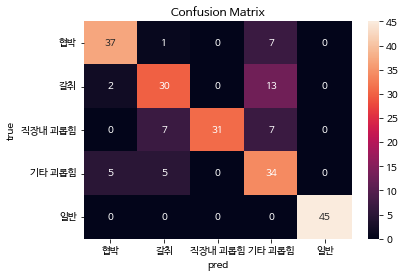

In [174]:
conf_matrix = confusion_matrix(y_true, y_pred)
names = ["협박", "갈취", "직장내 괴롭힘", "기타 괴롭힘", "일반"]
conf_matrix = pd.DataFrame(conf_matrix, index = names, columns = names)
sns.heatmap(conf_matrix, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.ylabel("true")
plt.xlabel("pred")
plt.show()

In [171]:
conf_matrix.style.background_gradient(cmap = "summer")

,협박,갈취,직장내 괴롭힘,기타 괴롭힘,일반
협박,37,1,0,7,0
갈취,2,30,0,13,0
직장내 괴롭힘,0,7,31,7,0
기타 괴롭힘,5,5,0,34,0
일반,0,0,0,0,45
